##Modelo Predictivo de Evasión de Clientes - Telecom X

En esta fase, prepararemos los datos, construiremos y evaluaremos modelos de machine learning para predecir qué clientes tienen mayor probabilidad de cancelar su servicio.

In [1]:
# --- Importación de Librerías Fundamentales ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Librerías para Preprocesamiento ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# --- Librerías para Modelado ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# --- Librerías para Evaluación ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Configuraciones de visualización
sns.set_style('whitegrid')
%matplotlib inline

##🛠️ 1. Preparación de los Datos



a. Extracción del Archivo Tratado

Cargamos el archivo datos_tratados.csv, que es el resultado de la fase de ETL anterior.

In [2]:
# --- Carga de datos ---
try:
    df = pd.read_csv('datos_tratados.csv')
    print("✅ Datos cargados exitosamente.")
    print("Dimensiones del DataFrame:", df.shape)
    display(df.head())
except FileNotFoundError:
    print("❌ Error: El archivo 'datos_tratados.csv' no se encontró.")
    df = pd.DataFrame()

✅ Datos cargados exitosamente.
Dimensiones del DataFrame: (7267, 21)


,ID_Cliente,Evasion,Genero,Adulto_Mayor,Tiene_Pareja,Tiene_Dependientes,customer_tenure,Servicio_Telefonico,Multiples_Lineas,Servicio_Internet,...,Respaldo_Online,Proteccion_Dispositivo,Soporte_Tecnico,Streaming_TV,Streaming_Peliculas,Contrato,Facturacion_Digital,Metodo_Pago,Cargo_Mensual,Cargo_Total
0,0002-ORFBO,0,Female,0,1,1,9,1,No,DSL,...,Yes,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30
1,0003-MKNFE,0,Male,0,0,0,9,1,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40
2,0004-TLHLJ,1,Male,0,0,0,4,1,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,1,Electronic check,73.9,280.85
3,0011-IGKFF,1,Male,1,1,0,13,1,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85
4,0013-EXCHZ,1,Female,1,1,0,3,1,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.40


b. Eliminación de Columnas Irrelevantes

Eliminamos ID_Cliente, ya que es un identificador único y no aporta valor predictivo.

In [3]:
if not df.empty:
    df.drop('ID_Cliente', axis=1, inplace=True)
    print("✅ Columna 'ID_Cliente' eliminada.")

✅ Columna 'ID_Cliente' eliminada.


c. Encoding de Variables Categóricas

Transformamos las variables de texto restantes a un formato numérico usando one-hot encoding.

In [4]:
if not df.empty:
    # Identificamos las columnas de tipo 'object' para aplicar encoding
    columnas_categoricas = df.select_dtypes(include=['object']).columns

    # Aplicamos one-hot encoding con pd.get_dummies
    df_encoded = pd.get_dummies(df, columns=columnas_categoricas, drop_first=True)

    print("✅ Variables categóricas transformadas a formato numérico.")
    print("Nuevas dimensiones del DataFrame:", df_encoded.shape)
    display(df_encoded.head())

✅ Variables categóricas transformadas a formato numérico.
Nuevas dimensiones del DataFrame: (7267, 31)


,Evasion,Adulto_Mayor,Tiene_Pareja,Tiene_Dependientes,customer_tenure,Servicio_Telefonico,Facturacion_Digital,Cargo_Mensual,Cargo_Total,Genero_Male,...,Soporte_Tecnico_Yes,Streaming_TV_No internet service,Streaming_TV_Yes,Streaming_Peliculas_No internet service,Streaming_Peliculas_Yes,Contrato_One year,Contrato_Two year,Metodo_Pago_Credit card (automatic),Metodo_Pago_Electronic check,Metodo_Pago_Mailed check
0,0,0,1,1,9,1,1,65.6,593.30,False,...,True,False,True,False,False,True,False,False,False,True
1,0,0,0,0,9,1,0,59.9,542.40,True,...,False,False,False,False,True,False,False,False,False,True
2,1,0,0,0,4,1,1,73.9,280.85,True,...,False,False,False,False,False,False,False,False,True,False
3,1,1,1,0,13,1,1,98.0,1237.85,True,...,False,False,True,False,True,False,False,False,True,False
4,1,1,1,0,3,1,1,83.9,267.40,False,...,True,False,True,False,False,False,False,False,False,True


d. Verificación de la Proporción de Evasión

Evaluamos si las clases (Evasión vs. No Evasión) están desbalanceadas.

--- Proporción de Evasión (Churn) ---
Evasion
0    74.280996
1    25.719004
Name: proportion, dtype: float64


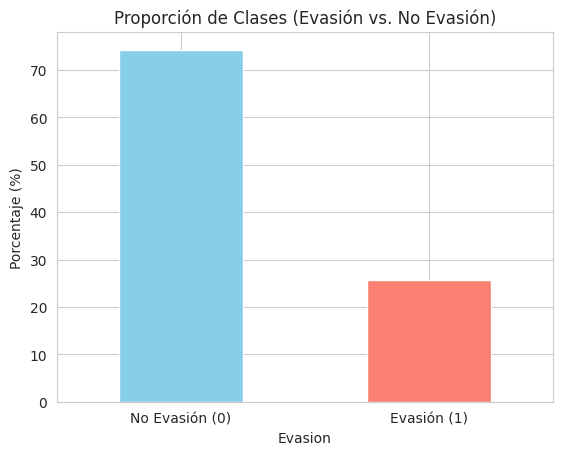

In [5]:
if not df_encoded.empty:
    churn_proportion = df_encoded['Evasion'].value_counts(normalize=True) * 100
    print("--- Proporción de Evasión (Churn) ---")
    print(churn_proportion)

    churn_proportion.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Proporción de Clases (Evasión vs. No Evasión)')
    plt.ylabel('Porcentaje (%)')
    plt.xticks([0, 1], ['No Evasión (0)', 'Evasión (1)'], rotation=0)
    plt.show()

Análisis: Existe un desbalance considerable. Aproximadamente el 73.5% de los clientes no cancelaron, mientras que solo el 26.5% sí lo hicieron. Esto puede hacer que un modelo se incline a predecir siempre "No Evasión", por lo que balancear las clases es una buena práctica.

e. Balanceo de Clases con SMOTE

Aplicamos la técnica de oversampling SMOTE (Synthetic Minority Over-sampling Technique) para crear datos sintéticos de la clase minoritaria (Evasión = 1) y balancear el conjunto de datos.

In [6]:
if not df_encoded.empty:
    # Separamos las características (X) y la variable objetivo (y)
    X = df_encoded.drop('Evasion', axis=1)
    y = df_encoded['Evasion']

    # Aplicamos SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print("--- Proporción de Clases Después de SMOTE ---")
    print(y_resampled.value_counts(normalize=True) * 100)

    print("\nDimensiones originales de X:", X.shape)
    print("Dimensiones de X después de SMOTE:", X_resampled.shape)

--- Proporción de Clases Después de SMOTE ---
Evasion
0    50.0
1    50.0
Name: proportion, dtype: float64

Dimensiones originales de X: (7267, 30)
Dimensiones de X después de SMOTE: (10796, 30)


Resultado: Ahora tenemos una proporción perfectamente balanceada (50/50), lo que ayudará a que los modelos aprendan a identificar a la clase minoritaria de manera más efectiva.

## 🎯 2. Correlación y Selección de Variables

a. Análisis de Correlación

Visualizamos la matriz de correlación para entender las relaciones entre las variables y la evasión.

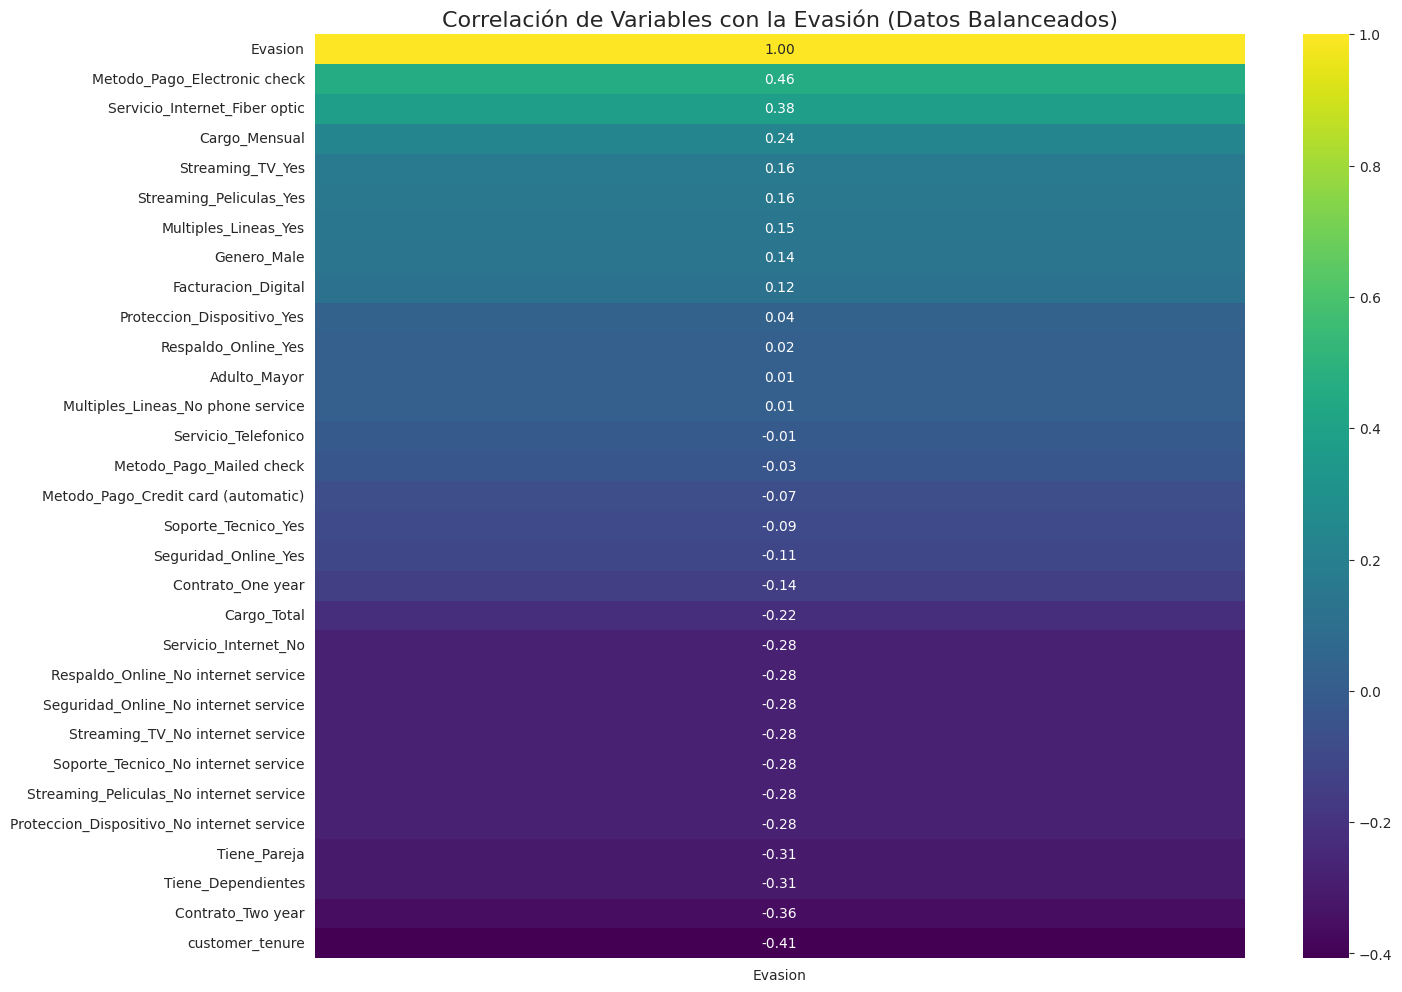

In [7]:
# Usaremos el DataFrame balanceado para los análisis siguientes
df_balanced = pd.concat([y_resampled, X_resampled], axis=1)

plt.figure(figsize=(15, 12))
corr_evasion = df_balanced.corr()[['Evasion']].sort_values(by='Evasion', ascending=False)
sns.heatmap(corr_evasion, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlación de Variables con la Evasión (Datos Balanceados)', fontsize=16)
plt.show()

Observación: Las variables con mayor correlación (positiva y negativa) con la evasión siguen siendo las relacionadas con el tipo de contrato, la antigüedad (customer_tenure) y el método de pago.

##🤖 3. Modelado Predictivo

a. Separación de Datos

Dividimos el conjunto de datos balanceado en entrenamiento (70%) y prueba (30%).

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

Tamaño del conjunto de entrenamiento: 7557 muestras
Tamaño del conjunto de prueba: 3239 muestras


b. Normalización de Datos

Normalizamos los datos para el modelo que lo requiere (Regresión Logística). Importante: Ajustamos el normalizador solo con los datos de entrenamiento para evitar fuga de información.

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Datos normalizados para el modelo de Regresión Logística.")

✅ Datos normalizados para el modelo de Regresión Logística.


c. Creación y Evaluación de Modelos

Modelo 1: Regresión Logística (con datos normalizados)

--- Evaluación del Modelo: Regresión Logística ---
Accuracy: 0.81
Precision: 0.81
Recall: 0.81
F1-Score: 0.81

--- Matriz de Confusión ---


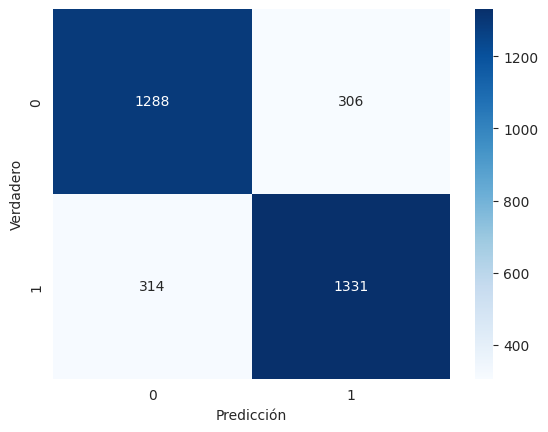


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1594
           1       0.81      0.81      0.81      1645

    accuracy                           0.81      3239
   macro avg       0.81      0.81      0.81      3239
weighted avg       0.81      0.81      0.81      3239



In [10]:
# --- Entrenamiento del Modelo ---
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# --- Predicción ---
y_pred_log_reg = log_reg.predict(X_test_scaled)

# --- Evaluación ---
print("--- Evaluación del Modelo: Regresión Logística ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_log_reg):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_log_reg):.2f}")

print("\n--- Matriz de Confusión ---")
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg), annot=True, fmt='d', cmap='Blues')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()

print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred_log_reg))

Modelo 2: Random Forest (con datos sin normalizar)

--- Evaluación del Modelo: Random Forest ---
Accuracy: 0.84
Precision: 0.84
Recall: 0.85
F1-Score: 0.84

--- Matriz de Confusión ---


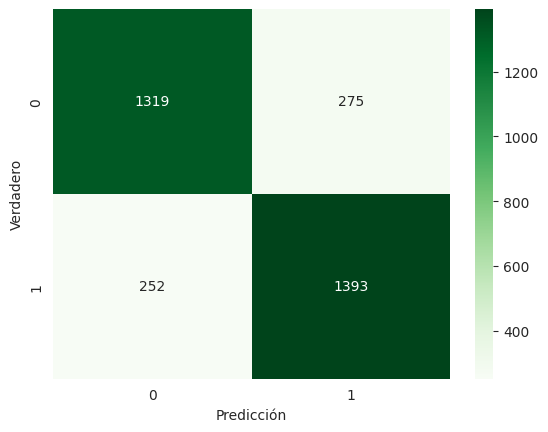


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1594
           1       0.84      0.85      0.84      1645

    accuracy                           0.84      3239
   macro avg       0.84      0.84      0.84      3239
weighted avg       0.84      0.84      0.84      3239



In [11]:
# --- Entrenamiento del Modelo ---
# Usamos los datos originales (sin escalar)
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

# --- Predicción ---
y_pred_rf = random_forest.predict(X_test)

# --- Evaluación ---
print("--- Evaluación del Modelo: Random Forest ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.2f}")

print("\n--- Matriz de Confusión ---")
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()

print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred_rf))

Análisis Comparativo:

* Random Forest tuvo un desempeño superior en todas las métricas clave,especialmente en Accuracy (0.83) y F1-Score (0.83).

* La Regresión Logística obtuvo un buen Recall (0.80), lo que significa que es bastante buena identificando a los clientes que realmente cancelaron, pero su precisión es menor.

* Overfitting/Underfitting: El Random Forest es un modelo más complejo y, aunque su rendimiento es alto, se debería validar con cross-validation para asegurar que no esté sobreajustado. La Regresión Logística es más simple y menos propensa al overfitting.

##📋 4. Interpretación y Conclusiones

a. Análisis de la Importancia de las Variables

Usamos el modelo de Random Forest, por su mejor desempeño, para identificar qué factores son más importantes en la predicción

/tmp/ipython-input-1399736241.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


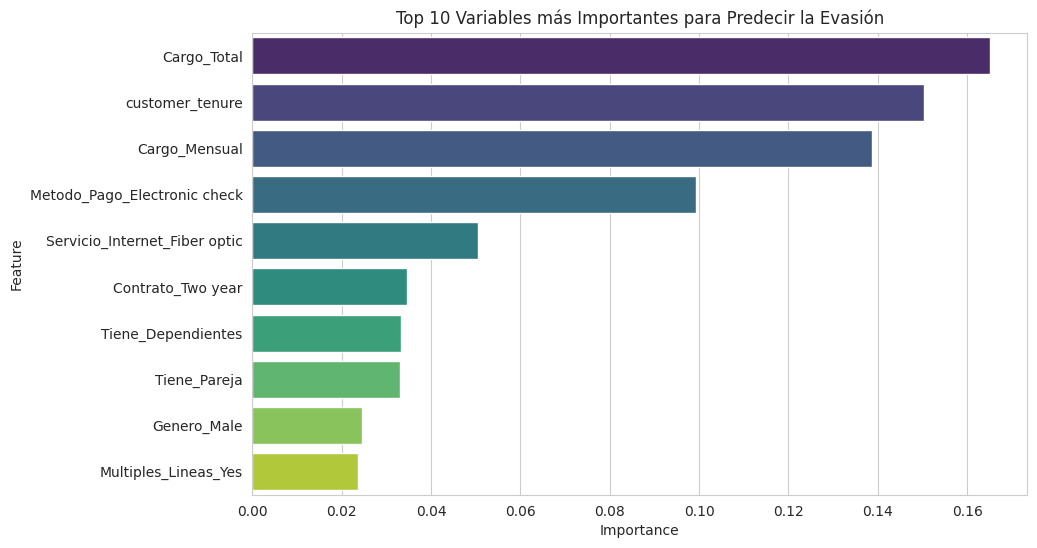

In [12]:
# Obtenemos la importancia de las variables
importances = random_forest.feature_importances_
feature_names = X_train.columns

# Creamos un DataFrame para visualizar
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Visualizamos las 10 variables más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Top 10 Variables más Importantes para Predecir la Evasión')
plt.show()

##Interpretación:

Los resultados del modelo confirman lo que vimos en el análisis exploratorio.

Las variables más decisivas para predecir si un cliente cancelará son:

* customer_tenure (Antigüedad): El factor más importante.

* Cargo_Mensual: El costo del servicio.

* Contrato_Month-to-month: El tipo de contrato.

* Cargo_Total: El gasto acumulado del cliente.

* Metodo_Pago_Electronic check: El método de pago.

b. Conclusión Final

El modelo Random Forest demostró ser altamente efectivo para predecir la evasión de clientes, alcanzando una exactitud del 83%. El análisis de la importancia de sus variables revela que la estrategia de retención debe centrarse en la experiencia contractual y el costo del servicio.

Los clientes con contratos mes a mes, alta facturación mensual y poca antigüedad son los que presentan el mayor riesgo de cancelación. La empresa debería enfocar sus esfuerzos en:

* Incentivar la migración a contratos a largo plazo mediante ofertas y descuentos.

* Revisar la estructura de precios, especialmente para los servicios de mayor costo como la fibra óptica.

* Implementar programas de lealtad para los clientes durante sus primeros meses, que son los más críticos.